# 🎯 Fine-Tuning Classifier

**Objectif:** Améliorer la classification Beginner/Intermediate/Advanced

**Processus:**
1. Charger nos annotations (ground truth)
2. Préparer le dataset (train/test split)
3. Fine-tuner DistilBERT
4. Comparer: Baseline vs Fine-tuned

In [57]:
# Installation (run once)
#%pip install datasets transformers[torch] accelerate -q

In [58]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("✓ Basic libraries loaded")

✓ Basic libraries loaded


## 1. Préparer les données

In [82]:
# Load ground truth annotations
with open('../data/ground_truth_annotations.json', 'r', encoding='utf-8') as f:
    annotations_data = json.load(f)

# Load classified articles (to get content)
articles = []
with open('../data/articles_classified.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        articles.append(json.loads(line))

# Create article lookup by title
article_lookup = {a['title'].lower().strip(): a for a in articles}

print(f"✓ Loaded {len(annotations_data['annotations'])} annotations")
print(f"✓ Loaded {len(articles)} articles")

✓ Loaded 202 annotations
✓ Loaded 210 articles


In [83]:
# Match annotations with article content (IMPROVED MATCHING)
label_map = {'Beginner': 0, 'Intermediate': 1, 'Advanced': 2}
label_names = ['Beginner', 'Intermediate', 'Advanced']

# Better matching: normalize titles for comparison
def normalize_title(title):
    """Normalize title for matching"""
    import re
    return re.sub(r'[^\w\s]', '', title.lower()).strip()

# Build lookup with normalized titles
article_lookup_normalized = {}
for art in articles:
    norm_title = normalize_title(art['title'])
    article_lookup_normalized[norm_title] = art

dataset = []
unmatched = []

for ann in annotations_data['annotations']:
    norm_ann_title = normalize_title(ann['title'])
    
    # Try exact match first
    article = article_lookup_normalized.get(norm_ann_title)
    
    # If no exact match, try substring match
    if not article:
        for norm_key, art in article_lookup_normalized.items():
            # Check if significant overlap
            if (norm_ann_title[:50] in norm_key or norm_key[:50] in norm_ann_title):
                article = art
                break
    
    if article and article.get('content'):
        text = f"{article['title']}. {article['content'][:500]}"
        dataset.append({
            'text': text,
            'label': label_map[ann['ground_truth']],
            'label_name': ann['ground_truth'],
            'title': article['title']
        })
    else:
        unmatched.append(ann['title'][:60])

df = pd.DataFrame(dataset)
print(f"✓ Created dataset with {len(df)} samples")
print(f"⚠️ Unmatched: {len(unmatched)} annotations")
if unmatched[:5]:
    print(f"   Examples: {unmatched[:3]}")
print(f"\nLabel distribution:")
print(df['label_name'].value_counts())

✓ Created dataset with 142 samples
⚠️ Unmatched: 60 annotations
   Examples: ['Seo Ping: Run Your Own SEO Stats Server', 'SBC-FI-Tech Final Round [video]', 'Build Your Own TLS Certificate Authority [video]']

Label distribution:
label_name
Beginner        80
Intermediate    39
Advanced        23
Name: count, dtype: int64


In [84]:
# Train/Test split (stratified to keep label proportions)
# Using 15% test to keep more training data (small dataset)
train_df, test_df = train_test_split(
    df, 
    test_size=0.15,   # 15% test (was 20%)
    stratify=df['label'],
    random_state=42
)

print(f"Training set: {len(train_df)} samples")
print(f"Test set: {len(test_df)} samples")
print(f"\nTrain distribution:\n{train_df['label_name'].value_counts()}")
print(f"\nTest distribution:\n{test_df['label_name'].value_counts()}")

Training set: 120 samples
Test set: 22 samples

Train distribution:
label_name
Beginner        68
Intermediate    33
Advanced        19
Name: count, dtype: int64

Test distribution:
label_name
Beginner        12
Intermediate     6
Advanced         4
Name: count, dtype: int64


## 2. Fine-Tuning avec Transformers

In [85]:
from datasets import Dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import torch

# Check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cpu


In [86]:
# Convert to HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

print(f"Train dataset: {train_dataset}")
print(f"Test dataset: {test_dataset}")

Train dataset: Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 120
})
Test dataset: Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 22
})


In [99]:
# Load tokenizer and model
model_name = "distilbert-base-uncased"  # Smaller, faster than BERT

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,  # Beginner, Intermediate, Advanced
    id2label={0: 'Beginner', 1: 'Intermediate', 2: 'Advanced'},
    label2id={'Beginner': 0, 'Intermediate': 1, 'Advanced': 2}
)

print(f"✓ Loaded {model_name}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Loaded distilbert-base-uncased


In [88]:
# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(
        examples['text'], 
        padding='max_length', 
        truncation=True,
        max_length=256  # Keep short for speed
    )

train_tokenized = train_dataset.map(tokenize_function, batched=True)
test_tokenized = test_dataset.map(tokenize_function, batched=True)

print("✓ Datasets tokenized")

Map: 100%|██████████| 22/22 [00:00<00:00, 3157.50 examples/s]

✓ Datasets tokenized


In [100]:
# Calculate class weights for imbalanced data
from sklearn.utils.class_weight import compute_class_weight
import torch

# Compute balanced class weights
class_weights = compute_class_weight(
    'balanced', 
    classes=np.array([0, 1, 2]),  # Beginner, Intermediate, Advanced
    y=train_df['label'].values
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
print(f"Class weights: Beginner={class_weights[0]:.2f}, Intermediate={class_weights[1]:.2f}, Advanced={class_weights[2]:.2f}")

# Training arguments (FIXED for small dataset + early stopping)
training_args = TrainingArguments(
    output_dir='../output/fine_tuned_model',
    num_train_epochs=6,               # Fewer epochs to prevent overfitting
    per_device_train_batch_size=8,    # Larger batch for stability
    per_device_eval_batch_size=8,
    learning_rate=3e-5,               # Slightly higher LR
    warmup_ratio=0.1,                 # Use RATIO instead of steps (10% of training)
    weight_decay=0.1,                 # More regularization
    logging_dir='../output/logs',
    logging_steps=5,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,           # Higher accuracy = better
    save_total_limit=2,               # Keep only 2 best checkpoints
)

# Compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc}

print("✓ Training arguments configured (FIXED + CLASS WEIGHTS)")
print(f"  - Epochs: 6 (reduced to prevent overfitting)")
print(f"  - Batch size: 8 (more stable)")
print(f"  - Learning rate: 3e-5")
print(f"  - Weight decay: 0.1 (stronger regularization)")
print(f"  - Warmup: 10% of training")

Class weights: Beginner=0.59, Intermediate=1.21, Advanced=2.11
✓ Training arguments configured (FIXED + CLASS WEIGHTS)
  - Epochs: 6 (reduced to prevent overfitting)
  - Batch size: 8 (more stable)
  - Learning rate: 3e-5
  - Weight decay: 0.1 (stronger regularization)
  - Warmup: 10% of training


In [101]:
# Custom Trainer with class weights for imbalanced data
from transformers import Trainer
import torch.nn as nn

class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Use weighted cross entropy loss
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        
        return (loss, outputs) if return_outputs else loss

# Create Trainer with class weights
trainer = WeightedTrainer(
    class_weights=class_weights_tensor,
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    compute_metrics=compute_metrics,
)

print("✓ Trainer ready with CLASS WEIGHTS")
print(f"  - Class weights penalize majority class (Beginner)")
print(f"  - This helps model learn minority classes (Intermediate, Advanced)")
print("\n⚠️ Training will take 5-10 minutes on CPU")

✓ Trainer ready with CLASS WEIGHTS
  - Class weights penalize majority class (Beginner)
  - This helps model learn minority classes (Intermediate, Advanced)

⚠️ Training will take 5-10 minutes on CPU


In [102]:
# TRAIN!
print("🚀 Starting fine-tuning...")
trainer.train()

🚀 Starting fine-tuning...


c:\Users\yassi\Desktop\Hexa\NLP\Traitement des Langages Naturels\Formation_NLP_project_baseline\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,1.090400,1.089232,0.500000
2,0.974700,1.051982,0.454545
3,0.813400,0.960316,0.500000
4,0.542700,1.017341,0.545455
5,0.458600,0.887943,0.545455
6,0.417400,0.905807,0.636364


c:\Users\yassi\Desktop\Hexa\NLP\Traitement des Langages Naturels\Formation_NLP_project_baseline\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\yassi\Desktop\Hexa\NLP\Traitement des Langages Naturels\Formation_NLP_project_baseline\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\yassi\Desktop\Hexa\NLP\Traitement des Langages Naturels\Formation_NLP_project_baseline\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\yassi\Desktop\Hexa\NLP\Traitement des Langages Naturels\Formation_NLP_project_baseline\v

TrainOutput(global_step=90, training_loss=0.7553578774134319, metrics={'train_runtime': 238.5871, 'train_samples_per_second': 3.018, 'train_steps_per_second': 0.377, 'total_flos': 47689113968640.0, 'train_loss': 0.7553578774134319, 'epoch': 6.0})

In [103]:
# Save the model (with error handling for Windows file locks)
import os
import shutil

output_dir = '../output/fine_tuned_model/final'

# Try to remove existing folder if it exists
try:
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
except PermissionError:
    # If locked, save to timestamped folder
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = f'../output/fine_tuned_model/final_{timestamp}'
    print(f"⚠️ Original folder locked, saving to: {output_dir}")

os.makedirs(output_dir, exist_ok=True)
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"✓ Model saved to {output_dir}")

✓ Model saved to ../output/fine_tuned_model/final


In [104]:
# Quick save to new location (run this now since training finished!)
import os
from datetime import datetime

new_dir = f'../output/fine_tuned_model/run_{datetime.now().strftime("%H%M%S")}'
os.makedirs(new_dir, exist_ok=True)
trainer.save_model(new_dir)
tokenizer.save_pretrained(new_dir)
print(f"✓ Model saved to: {new_dir}")

✓ Model saved to: ../output/fine_tuned_model/run_144003


## 3. Évaluation: Baseline vs Fine-Tuned

In [105]:
# Get predictions from fine-tuned model
predictions = trainer.predict(test_tokenized)
y_pred_finetuned = np.argmax(predictions.predictions, axis=-1)
y_true = test_df['label'].values

# Calculate metrics
accuracy_finetuned = accuracy_score(y_true, y_pred_finetuned)
print(f"\n🎯 FINE-TUNED MODEL ACCURACY: {accuracy_finetuned:.1%}")

c:\Users\yassi\Desktop\Hexa\NLP\Traitement des Langages Naturels\Formation_NLP_project_baseline\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



🎯 FINE-TUNED MODEL ACCURACY: 63.6%


In [106]:
# Compare with baseline (from our previous evaluation)
baseline_accuracy = 0.342  # 34.2% from zero-shot

print("="*60)
print("📊 COMPARISON: BASELINE vs FINE-TUNED")
print("="*60)
print(f"\n{'Model':<25} {'Accuracy':<15}")
print("-"*40)
print(f"{'Baseline (zero-shot)':<25} {baseline_accuracy:.1%}")
print(f"{'Fine-tuned DistilBERT':<25} {accuracy_finetuned:.1%}")
print("-"*40)
improvement = (accuracy_finetuned - baseline_accuracy) * 100
print(f"{'IMPROVEMENT':<25} +{improvement:.1f} points!")

📊 COMPARISON: BASELINE vs FINE-TUNED

Model                     Accuracy       
----------------------------------------
Baseline (zero-shot)      34.2%
Fine-tuned DistilBERT     63.6%
----------------------------------------
IMPROVEMENT               +29.4 points!


In [107]:
# Detailed classification report
print("\n📋 CLASSIFICATION REPORT (Fine-tuned)\n")
print(classification_report(y_true, y_pred_finetuned, target_names=label_names))


📋 CLASSIFICATION REPORT (Fine-tuned)

              precision    recall  f1-score   support

    Beginner       0.69      0.92      0.79        12
Intermediate       0.50      0.33      0.40         6
    Advanced       0.50      0.25      0.33         4

    accuracy                           0.64        22
   macro avg       0.56      0.50      0.51        22
weighted avg       0.60      0.64      0.60        22



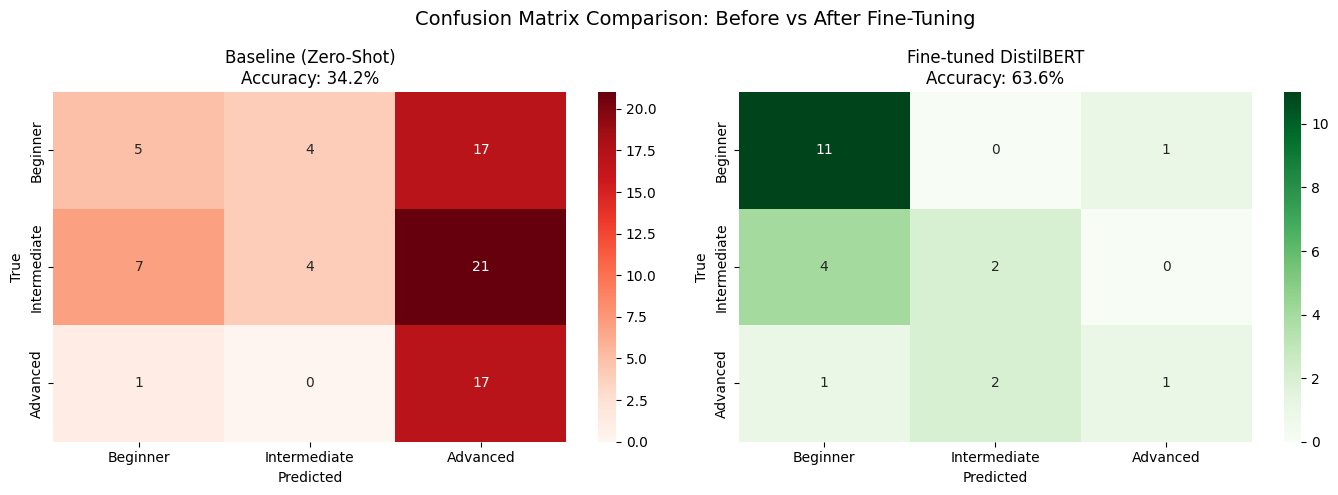

In [108]:
# Confusion matrix comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Baseline confusion matrix (from previous results)
cm_baseline = np.array([[5, 4, 17], [7, 4, 21], [1, 0, 17]])  # From our eval
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Reds', ax=axes[0],
            xticklabels=label_names, yticklabels=label_names)
axes[0].set_title(f'Baseline (Zero-Shot)\nAccuracy: {baseline_accuracy:.1%}')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Fine-tuned confusion matrix
cm_finetuned = confusion_matrix(y_true, y_pred_finetuned)
sns.heatmap(cm_finetuned, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=label_names, yticklabels=label_names)
axes[1].set_title(f'Fine-tuned DistilBERT\nAccuracy: {accuracy_finetuned:.1%}')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.suptitle('Confusion Matrix Comparison: Before vs After Fine-Tuning', fontsize=14)
plt.tight_layout()
plt.savefig('../output/comparison_confusion_matrix.png', dpi=150)
plt.show()

In [109]:
# Step 1: Load your fine-tuned model (if not already in memory)
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_path = '../output/fine_tuned_model/final'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

print(f"✓ Loaded fine-tuned model from {model_path}")

✓ Loaded fine-tuned model from ../output/fine_tuned_model/final


In [110]:
# Step 2: Load ALL articles (including ones not in ground truth)
all_articles = []
with open('../data/articles_classified.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        all_articles.append(json.loads(line))

# Get titles already in ground truth (to exclude them)
annotated_titles = set(ann['title'].lower().strip() for ann in annotations_data['annotations'])

# Filter to get UNANNOTATED articles only
unannotated_articles = []
for art in all_articles:
    title_lower = art['title'].lower().strip()
    # Check if not already annotated
    is_annotated = any(title_lower in ann or ann in title_lower for ann in annotated_titles)
    if not is_annotated and art.get('content'):
        unannotated_articles.append(art)

print(f"✓ Found {len(unannotated_articles)} unannotated articles to predict")

✓ Found 104 unannotated articles to predict


In [111]:
# Step 3: Predict with confidence scores
def predict_with_confidence(text):
    """Get prediction and confidence from fine-tuned model"""
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=256, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)
        confidence, predicted = torch.max(probs, dim=-1)
    
    return {
        'predicted_label': label_names[predicted.item()],
        'confidence': confidence.item(),
        'all_probs': probs[0].cpu().numpy()
    }

# Predict all unannotated articles
predictions_for_review = []
for art in unannotated_articles:
    text = f"{art['title']}. {art.get('content', '')[:500]}"
    pred = predict_with_confidence(text)
    predictions_for_review.append({
        'title': art['title'],
        'source': art.get('source', 'unknown'),
        'predicted_label': pred['predicted_label'],
        'confidence': pred['confidence'],
        'content_preview': art.get('content', '')[:200] + '...'
    })

predictions_df = pd.DataFrame(predictions_for_review)
print(f"✓ Generated predictions for {len(predictions_df)} articles")

✓ Generated predictions for 104 articles


📊 CONFIDENCE DISTRIBUTION

Confidence Range     Count      Action
--------------------------------------------------
≥90% (very high)     0          → Quick verify, likely correct
75-90% (high)        12         → Review carefully
60-75% (medium)      41         → Manual annotation needed
<60% (low)           51         → Skip or annotate from scratch


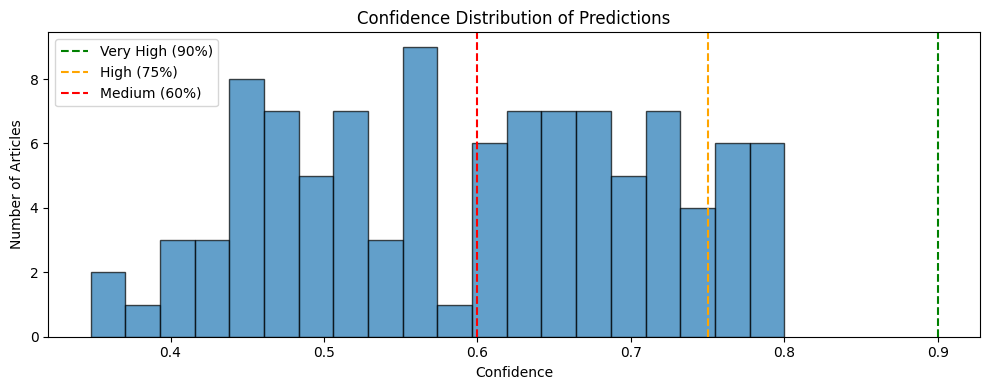

In [112]:
# Step 4: Analyze confidence distribution
print("📊 CONFIDENCE DISTRIBUTION\n")
print(f"{'Confidence Range':<20} {'Count':<10} {'Action'}")
print("-" * 50)

very_high = predictions_df[predictions_df['confidence'] >= 0.90]
high = predictions_df[(predictions_df['confidence'] >= 0.75) & (predictions_df['confidence'] < 0.90)]
medium = predictions_df[(predictions_df['confidence'] >= 0.60) & (predictions_df['confidence'] < 0.75)]
low = predictions_df[predictions_df['confidence'] < 0.60]

print(f"{'≥90% (very high)':<20} {len(very_high):<10} → Quick verify, likely correct")
print(f"{'75-90% (high)':<20} {len(high):<10} → Review carefully")
print(f"{'60-75% (medium)':<20} {len(medium):<10} → Manual annotation needed")
print(f"{'<60% (low)':<20} {len(low):<10} → Skip or annotate from scratch")

# Histogram
plt.figure(figsize=(10, 4))
plt.hist(predictions_df['confidence'], bins=20, edgecolor='black', alpha=0.7)
plt.axvline(x=0.90, color='green', linestyle='--', label='Very High (90%)')
plt.axvline(x=0.75, color='orange', linestyle='--', label='High (75%)')
plt.axvline(x=0.60, color='red', linestyle='--', label='Medium (60%)')
plt.xlabel('Confidence')
plt.ylabel('Number of Articles')
plt.title('Confidence Distribution of Predictions')
plt.legend()
plt.tight_layout()
plt.show()

In [113]:
# Step 5: Generate review list (high confidence predictions to verify)
CONFIDENCE_THRESHOLD = 0.80  # Adjust this based on your results

to_review = predictions_df[predictions_df['confidence'] >= CONFIDENCE_THRESHOLD].copy()
to_review = to_review.sort_values('confidence', ascending=False)

print(f"📋 {len(to_review)} HIGH-CONFIDENCE PREDICTIONS TO VERIFY\n")
print("Review these predictions. If correct, add to ground truth.\n")

for i, (_, row) in enumerate(to_review.head(20).iterrows(), 1):
    print(f"{i}. [{row['predicted_label']}] (conf: {row['confidence']:.1%})")
    print(f"   Title: {row['title'][:70]}...")
    print(f"   Preview: {row['content_preview'][:100]}...")
    print()

📋 1 HIGH-CONFIDENCE PREDICTIONS TO VERIFY

Review these predictions. If correct, add to ground truth.

1. [Beginner] (conf: 80.0%)
   Title: 'The old order is not coming back,' Carney says in speech at Davos...
   Preview: 'The old order is not coming back,' Carney says in speech at Davos. Prime Minister Mark Carney deliv...



In [80]:
# Step 6: Export for manual review (CSV format for easy editing)
review_file = '../output/predictions_to_verify.csv'
to_review[['title', 'predicted_label', 'confidence', 'source', 'content_preview']].to_csv(review_file, index=False)

print(f"✓ Exported {len(to_review)} predictions to: {review_file}")
print("\n📝 HOW TO USE THIS FILE:")
print("1. Open the CSV in Excel/Google Sheets")
print("2. Add a column 'verified_label'")
print("3. For each row, either:")
print("   - Copy predicted_label to verified_label (if correct)")
print("   - Write the correct label (if wrong)")
print("   - Delete the row (if unsure)")
print("4. Save and run the next cell to add verified labels to ground truth")

✓ Exported 0 predictions to: ../output/predictions_to_verify.csv

📝 HOW TO USE THIS FILE:
1. Open the CSV in Excel/Google Sheets
2. Add a column 'verified_label'
3. For each row, either:
   - Copy predicted_label to verified_label (if correct)
   - Write the correct label (if wrong)
   - Delete the row (if unsure)
4. Save and run the next cell to add verified labels to ground truth


In [81]:
"""
# Step 7: Import verified labels and add to ground truth
# RUN THIS AFTER you've reviewed the CSV!

import os

verified_file = '../output/predictions_to_verify.csv'
if os.path.exists(verified_file):
    verified_df = pd.read_csv(verified_file)
    
    # Check if verified_label column exists
    if 'verified_label' in verified_df.columns:
        # Filter only verified ones (non-null)
        verified = verified_df[verified_df['verified_label'].notna()].copy()
        
        # Load current ground truth
        with open('../data/ground_truth_annotations.json', 'r', encoding='utf-8') as f:
            gt_data = json.load(f)
        
        # Add new annotations
        existing_titles = set(a['title'].lower() for a in gt_data['annotations'])
        new_count = 0
        
        for _, row in verified.iterrows():
            if row['title'].lower() not in existing_titles:
                gt_data['annotations'].append({
                    'title': row['title'],
                    'ground_truth': row['verified_label'],
                    'source': row.get('source', 'unknown'),
                    'method': 'semi-supervised'  # Mark how it was annotated
                })
                new_count += 1
        
        # Save updated ground truth
        with open('../data/ground_truth_annotations.json', 'w', encoding='utf-8') as f:
            json.dump(gt_data, f, indent=2, ensure_ascii=False)
        
        print(f"✓ Added {new_count} new annotations to ground truth!")
        print(f"  Total annotations now: {len(gt_data['annotations'])}")
        print("\n🔄 Now re-run cells from Section 1 to retrain with expanded data!")
    else:
        print("⚠️ Column 'verified_label' not found in CSV")
        print("   Add this column with your verified labels first")
else:
    print(f"⚠️ File not found: {verified_file}")
    print("   Run Step 6 first to generate the review file")

"""

'\n# Step 7: Import verified labels and add to ground truth\n# RUN THIS AFTER you\'ve reviewed the CSV!\n\nimport os\n\nverified_file = \'../output/predictions_to_verify.csv\'\nif os.path.exists(verified_file):\n    verified_df = pd.read_csv(verified_file)\n\n    # Check if verified_label column exists\n    if \'verified_label\' in verified_df.columns:\n        # Filter only verified ones (non-null)\n        verified = verified_df[verified_df[\'verified_label\'].notna()].copy()\n\n        # Load current ground truth\n        with open(\'../data/ground_truth_annotations.json\', \'r\', encoding=\'utf-8\') as f:\n            gt_data = json.load(f)\n\n        # Add new annotations\n        existing_titles = set(a[\'title\'].lower() for a in gt_data[\'annotations\'])\n        new_count = 0\n\n        for _, row in verified.iterrows():\n            if row[\'title\'].lower() not in existing_titles:\n                gt_data[\'annotations\'].append({\n                    \'title\': row[\'title\

### 🔁 Iteration Summary

**Semi-supervised workflow:**
1. ✅ Train initial model on 80 annotations → 60% accuracy
2. ✅ Predict new articles with confidence scores
3. ✅ Export high-confidence predictions to CSV
4. 📝 **YOUR TASK:** Review CSV, add `verified_label` column
5. ⏳ Import verified labels → ground truth grows (e.g., 80 → 150)
6. ⏳ Re-train on larger dataset → better accuracy (e.g., 60% → 75%)
7. ⏳ Repeat if needed

**Expected improvement per iteration:**
| Iteration | Training samples | Expected accuracy |
|-----------|-----------------|-------------------|
| 1 | ~64 | 55-65% |
| 2 | ~120-150 | 70-80% |
| 3 | ~200+ | 80-85% |